# Data Analysis with Python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression, LinearRegression


In [12]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from dataset_creation import create_dataset
df = create_dataset(start_year=2013, end_year=2018)
df.shape

(314, 22)

## Data basic visualization

In [15]:
df.head()

salary  salary_next_year  added_salary      T  \
first_name last_name                                                     
Aaron      Long       11.082143         11.199926      0.125000   True   
           Maund      11.058000         11.390187      0.394014   True   
Adam       Moffat     11.992931         12.081690      0.092817  False   
Adolfo     Machado    12.285364         12.373737      0.092396  False   
Alan       Gordon     12.189266         12.238862      0.050847  False   

                     age_group  team_name  shots_per_game  goals_per_game  \
first_name last_name                                                        
Aaron      Long          27-30   New York        0.647059        0.029412   
           Maund         30-35  Salt Lake        0.363636        0.045455   
Adam       Moffat          >35    Houston        1.076923        0.115385   
Adolfo     Machado         >35    Houston        0.289474        0.000000   
Alan       Gordon          >35   San Jose        1.666667        0.166667   

                      pass_success    rating  ...  assists_per_game  \
first_name last_name                          ...                     
Aaron      Long          76.465662  6.888824  ...          0.000000   
           Maund         73.575949  6.890000  ...          0.045455   
Adam       Moffat        80.550285  6.672308  ...          0.000000   
Adolfo     Machado       78.042328  6.950526  ...          0.052632   
Alan       Gordon        67.918089  6.555000  ...          0.083333   

                      age_group_next_year  team_name_next_year  \
first_name last_name                                             
Aaron      Long                     27-30             New York   
           Maund                    30-35            Salt Lake   
Adam       Moffat                     >35            FC Dallas   
Adolfo     Machado                    >35              Houston   
Alan       Gordon                     >35          L.A. Galaxy   

                     shots_per_game_next_year goals_per_game_next_year  \
first_name last_name                                                     
Aaron      Long                      0.684211                 0.078947   
           Maund                     0.250000                 0.000000   
Adam       Moffat                    0.700000                 0.000000   
Adolfo     Machado                   0.238095                 0.000000   
Alan       Gordon                    1.421053                 0.263158   

                      pass_success_next_year  rating_next_year  \
first_name last_name                                             
Aaron      Long                    69.554849          7.077632   
           Maund                   79.483037          6.974000   
Adam       Moffat                  80.132450          6.543000   
Adolfo     Machado                 80.699482          6.761905   
Alan       Gordon                  73.360656          6.668947   

                      minutes_per_game_next_year  \
first_name last_name                               
Aaron      Long                        83.315789   
           Maund                       87.300000   
Adam       Moffat                      57.600000   
Adolfo     Machado                     80.761905   
Alan       Gordon                      30.421053   

                      man_of_the_match_per_game_next_year  \
first_name last_name                                        
Aaron      Long                                  0.052632   
           Maund                                 0.100000   
Adam       Moffat                                0.000000   
Adolfo     Machado                               0.000000   
Alan       Gordon                                0.000000   

                      assists_per_game_next_year  
first_name last_name                              
Aaron      Long                         0.052632  
           Maund                        0.000000  
Adam       Moffat         

<AxesSubplot:>

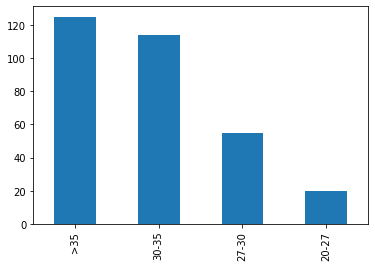

In [16]:
# age group distribution in a bar chart (age group is a categorical variable)
df["age_group"].value_counts().plot(kind="bar")


Correlation between added_salary and rating_next_year: -0.05


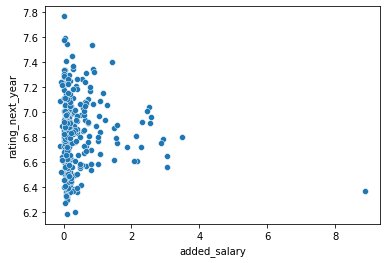

In [23]:
# next year rating based on added_salary 

sns.scatterplot(x="added_salary", y="rating_next_year", data=df)

# corr between added_salary and rating_next_year
corr = df[["added_salary", "rating_next_year"]].corr().loc["added_salary", "rating_next_year"]
print(f"Correlation between added_salary and rating_next_year: {corr:.2f}")

Text(0, 0.5, 'Count')

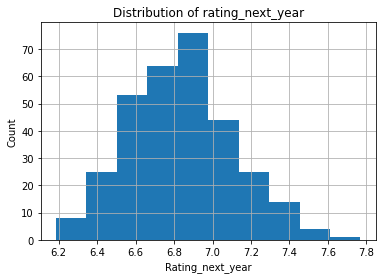

In [18]:
# distribution of rating_next_year continuous variable
df["rating_next_year"].hist()
plt.title("Distribution of rating_next_year")
plt.xlabel("Rating_next_year")
plt.ylabel("Count")

## Overlap between control and treatment groups

In [50]:
T = df["T"]

X = pd.get_dummies(df[[
                       "salary",
                       "age_group",
                       "team_name",
                       "rating", 
                       "team_name_next_year", 
                       "shots_per_game",
                       "goals_per_game",
                       "pass_success",
                       "minutes_per_game",
                       "man_of_the_match_per_game",
                       ]])

Y = df["rating_next_year"]

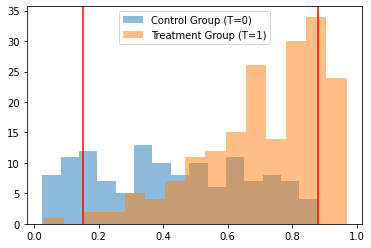

In [51]:
# calc propensity score
from sklearn.linear_model import LogisticRegression, LinearRegression

lr = LogisticRegression(max_iter=1000000)
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

# visualize propensity score
plt.hist(ps[T == 0], bins=15, alpha=0.5, label="Control Group (T=0)")
plt.hist(ps[T == 1], bins=15, alpha=0.5, label="Treatment Group (T=1)")
plt.legend()


# x line
low_threshold = 0.15 
high_threshold = 0.88
plt.axvline(low_threshold, color="red")
plt.axvline(high_threshold, color="red")


In [52]:
# trim outliers
X = X[(ps > low_threshold) & (ps < high_threshold)]
T = T[(ps > low_threshold) & (ps < high_threshold)]
Y = Y[(ps > low_threshold) & (ps < high_threshold)]
ps = ps[(ps > low_threshold) & (ps < high_threshold)]

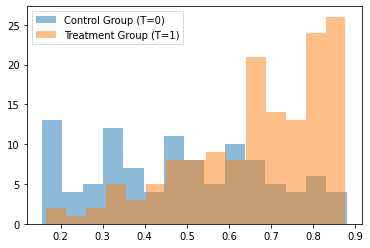

In [53]:
# Propensity after trimming
plt.hist(ps[T == 0], bins=15, alpha=0.5, label="Control Group (T=0)")
plt.hist(ps[T == 1], bins=15, alpha=0.5, label="Treatment Group (T=1)")
plt.legend()


In [54]:
data = X
data["T"] = T
data["Y"] = Y

## Analysis

In [55]:
from calc_ate import calculate_ATE


# estimate variance using bootstrap
def estimate_std(data, method="IPW", n_iter=1000, random_state=0, sample_size=None):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)

    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method))

    ate_list = np.array(ate_list)
    return ate_list.std()

def estimate_ci(data, method="IPW", n_iter=1000, random_state=0, sample_size=None, alpha=0.05):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)
    
    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method))
    
    ate_list = np.array(ate_list)
    ate_list.sort()
    lower = ate_list[int(n_iter * alpha / 2)]
    upper = ate_list[int(n_iter * (1 - alpha / 2))]
    return lower, upper



In [56]:
# tabulate all results
methods = ["IPW", "S-learner", "T-learner", "matching"]
results = pd.DataFrame(index=methods, columns=["ATE", "Std"])

for method in methods:
    results.loc[method, "ATE"] = calculate_ATE(data, method=method)
    results.loc[method, "Std"] = estimate_std(data, method=method, n_iter=500, sample_size=50)

    alpha = 0.05

    # calculate confidence interval
    lower, upper = estimate_ci(data, method=method, n_iter=500, sample_size=50, alpha=alpha)
    results.loc[method, f"ATE ({1 - alpha}% CI)"] = f"[{lower:.3f}, {upper:.3f}]"

    # results.loc[method, "ATE (95% CI)"] = f"{results.loc[method, 'ATE']:.3f} ± {1.96 * results.loc[method, 'std']:.3f}"

print(tabulate(results, headers="keys", tablefmt="github"))

|           |        ATE |      Std | ATE (0.95% CI)   |
|-----------|------------|----------|------------------|
| IPW       | -0.201607  | 6.33126  | [-20.537, 1.965] |
| S-learner |  0.0105027 | 0.135736 | [-0.245, 0.282]  |
| T-learner |  0.0234475 | 0.97601  | [-0.572, 0.489]  |
| matching  |  0         | 0        | [0.000, 0.000]   |
